<a href="https://colab.research.google.com/github/chel310/Trash_classifier/blob/main/trash_classifier_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets clone our repository initially

In [1]:
!git clone   https://github.com/chel310/Trash_classifier.git 
%cd Trash_classifier/

c:\vsc_codes\vsc_codes_py_livingLab\Trash_classifier\Trash_classifier


fatal: destination path 'Trash_classifier' already exists and is not an empty directory.


We will be using tensorflow as our default library for transfer learning. Code uasge  was based on [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for the same

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical,plot_model

Lets load our training images for processing

In [2]:
batch_size = 32
img_height = 224
img_width = 224
data_root = 'dataset_augmented/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14683 files belonging to 6 classes.
Using 11747 files for training.


In [3]:
class_names = np.array(train_ds.class_names)
print('class names for predictions :',class_names)

class names for predictions : ['glass' 'metal' 'paper' 'paper2' 'plastic' 'trash']


TensorFlow Hub's conventions for image models is to expect **float** inputs in the **[0, 1]** range. Use the **Rescaling layer** to achieve this.

In [4]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))


Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [7]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [8]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


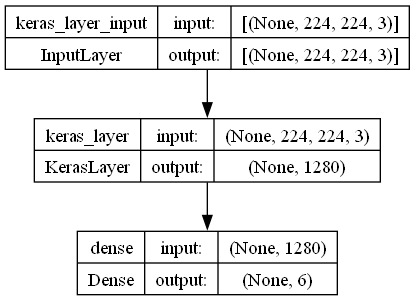

In [9]:
plot_model(model, show_shapes=True)

In [10]:
image_batch.shape

TensorShape([32, 224, 224, 3])

# Train the model

In [12]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

 To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [13]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=10,
                    callbacks=[batch_stats_callback])


Epoch 1/10


140/355 [==========>...................] - ETA: 51s - loss: 0.6073 - acc: 0.6875

: 

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

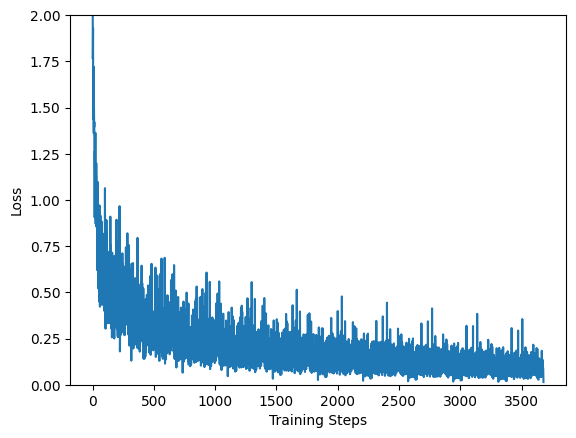

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

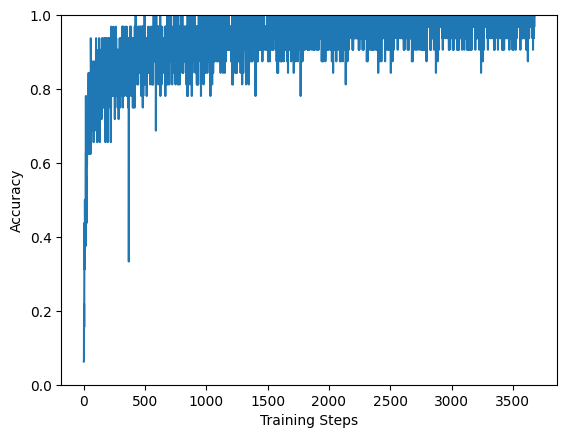

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

To redo the plot from before, first get the ordered list of class names:



In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


1/1 [==============================] - 1s 559ms/step


Plot the result

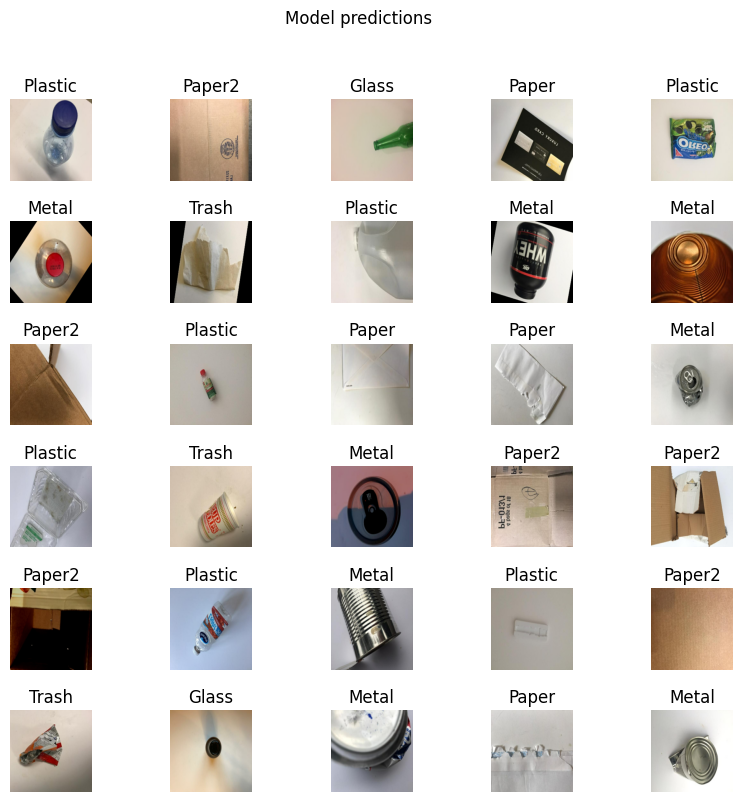

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")


## Save the Model

In [ ]:
t = time.time()

export_path = "saved_models/MobileNetV2"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/MobileNetV2\assets


INFO:tensorflow:Assets written to: saved_models/MobileNetV2\assets


'saved_models/MobileNetV2'